In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

from glob import glob

import IPython.display as ipd
from tqdm import tqdm

import subprocess as sp

plt.style.use('ggplot')

from useful_fn import *

DATA_PATH = "./data/"

In [4]:
witdh = 640
height = 480

video_name = "street0"

VIDEO_PATH_COMP = DATA_PATH + f"{video_name}_compresed.mp4"
VIDEO_PATH_EXP = DATA_PATH + f"{video_name}_exp.mp4"

In [5]:
#sp.run(['ffmpeg','-i', DATA_PATH + f"{video_name}.mp4", '-qscale', '0', VIDEO_PATH_COMP, '-loglevel', 'quiet'])

#sp.run(['ffmpeg', '-i', VIDEO_PATH_COMP, '-vf', f'scale={witdh}:{height}', VIDEO_PATH_EXP, '-loglevel', 'quiet'])

CompletedProcess(args=['ffmpeg', '-i', './data/street0_compresed.mp4', '-vf', 'scale=640:480', './data/street0_exp.mp4', '-loglevel', 'quiet'], returncode=0)

In [6]:
basic_info = get_basic_info(VIDEO_PATH_EXP)
basic_info

{'width': 640,
 'height': 480,
 'frames': 1255,
 'fps': 30.0,
 'total_seconds': 41.833333333333336}

In [7]:
ipd.Video(VIDEO_PATH_EXP, width=600)

In [5]:
! ls

Experiments.ipynb  data  requirements_notebooks.txt
__pycache__	   imgs  useful_fn.py


In [3]:
# Generate some images 
# generate_imgs(video=VIDEO_PATH_EXP, output="imgs/", every_n_frames=50)

# Display multiple frames from the video

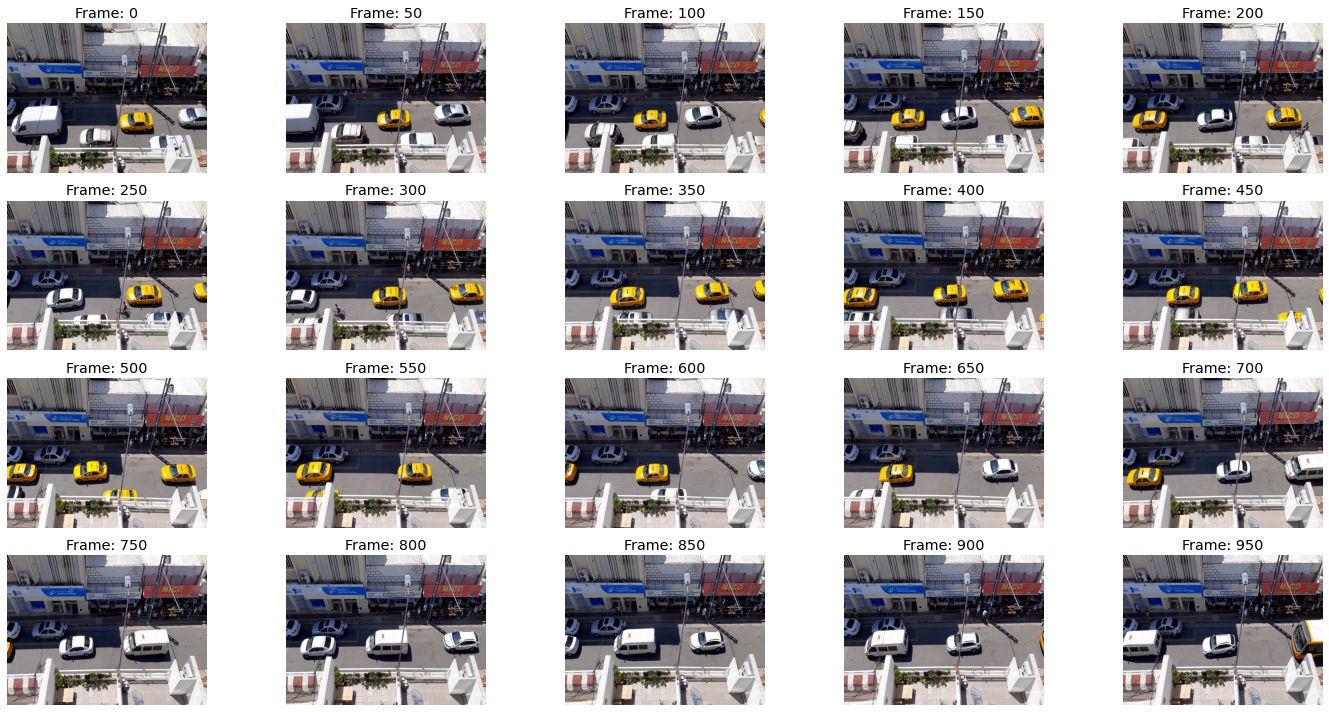

In [8]:
fig, axs = plt.subplots(4, 5, figsize=(20,10))
axs = axs.flatten()

cap = cv2.VideoCapture(VIDEO_PATH_EXP)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0
for frame_idx in range(n_frames):
    ret, img = cap.read()
    if not ret : break
    
    if (frame_idx % 50 == 0) and (img_idx < 20):
        axs[img_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[img_idx].set_title(f"Frame: {frame_idx}")
        axs[img_idx].axis("off")
        img_idx += 1
        
plt.tight_layout()
plt.show()
cap.release()

# Annotations

In [4]:
categories_map = {
    2 : "car"
}

In [5]:
annotations = get_annotations("train", witdh, height, categories_map)
annotations

,label_name,center_x,center_y,bbox_width,bbox_height,image_name
0,car,88.91008,313.36512,102.36992,58.00944,frame_0000.jpeg
1,car,545.59232,318.48336,119.43104,63.69648,frame_0000.jpeg
2,car,91.75360,312.79632,105.78176,56.87184,frame_0050.jpeg
3,car,394.31296,316.77744,105.78176,62.55936,frame_0050.jpeg
4,car,93.45984,309.38400,102.36992,63.69648,frame_0100.jpeg
...,...,...,...,...,...,...
58,car,463.12768,344.64432,168.34112,93.27024,frame_0900.jpeg
59,car,152.03776,342.93840,160.37888,85.30800,frame_0950.jpeg
60,car,566.63488,304.26528,120.56896,71.65872,frame_0950.jpeg
61,car,274.31296,300.28416,106.91968,68.24640,frame_1000.jpeg


In [16]:
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

In [7]:
def show_img_annotations(frame_file):
    img = cv2.imread(f"train/{frame_file}")
    font = cv2.FONT_HERSHEY_TRIPLEX
    img_example = img.copy()
    frame_labels = annotations.query(f"image_name == '{frame_file}'")
    for i, d in frame_labels.iterrows():
        img_center_x = d['center_x']
        img_center_y = d['center_y']
        img_width = d['bbox_width']
        img_height = d['bbox_height']

        pt1 = int(img_center_x - img_width/2), int(img_center_y + img_height/2)
        pt2 = int(img_center_x + img_width/2), int(img_center_y - img_height/2)
        img_example = cv2.rectangle(img_example, pt1, pt2, (0, 0, 255), 3)

        pt_text = pt1[0] + 5, pt1[1] + 10
        img_example = cv2.putText(img_example, d["label_name"], pt_text, font, 0.5, (0, 0, 255))

    display_cv2_img(img_example)

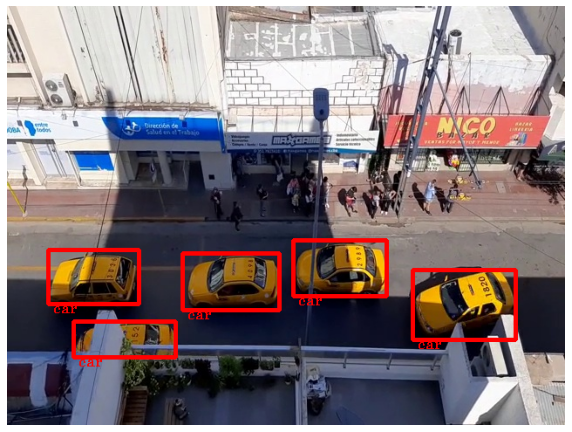

In [8]:
show_img_annotations("frame_0200.jpeg")

# Testing trained model

In [20]:
weights = "../models_deploy/V05/best.pt"
model_custom = torch.hub.load('ultralytics/yolov5', 'custom', weights) 

Using cache found in /home/maxi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.10.4 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [21]:
classes = { 0: "person", 1: "bicycle", 2: "car", 3: "motorcycle", 5: "bus" }

color_map = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (0, 150, 0),
    5: (0, 0, 100),
}

In [22]:
img_test = "train/frame_0200.jpeg"

In [23]:
def predict_as_df_ctm(img, conf_thres):
    results = model_custom(img)
    df = results.pandas().xyxy[0]
    df = df[df["name"].isin(list(classes.values()))]
    df = df[df['confidence'] >= conf_thres]
    return df 

predictions_custom = predict_as_df_ctm(img_test, 0.5)
predictions_custom

,xmin,ymin,xmax,ymax,confidence,class,name
0,467.586792,300.598938,579.720703,380.514954,0.921360,2,car
1,79.685379,359.742401,196.489731,401.858917,0.907603,2,car
2,201.889648,283.508942,313.789917,350.141876,0.901891,2,car
3,50.110340,281.003662,149.407669,343.272339,0.899450,2,car
4,329.774078,269.479187,433.551056,334.473877,0.897881,2,car


In [24]:
def show_img_predictions(frame_path, annotations):
    img = cv2.imread(frame_path)
    font = cv2.FONT_HERSHEY_TRIPLEX
    img_example = img.copy()
    
    for i, d in annotations.iterrows():
        xmin, ymin, xmax, ymax = d["xmin"], d["ymin"], d["xmax"], d["ymax"]

        color = color_map[d['class']]

        pt1 = int(xmin), int(ymin)
        pt2 = int(xmax), int(ymax)
        img_example = cv2.rectangle(img_example, pt1, pt2, color, 3)

        pt_text = pt1[0] + 5, pt1[1] + 10
        img_example = cv2.putText(img_example, d["name"], pt_text, font, 0.5, color)

        confidence_label = f"{d['confidence']:.2f}"
        pt_conf = pt2[0] + 5, pt2[1] + 10
        img_example = cv2.putText(img_example, confidence_label, pt_conf, font, 0.5, color)

    display_cv2_img(img_example)

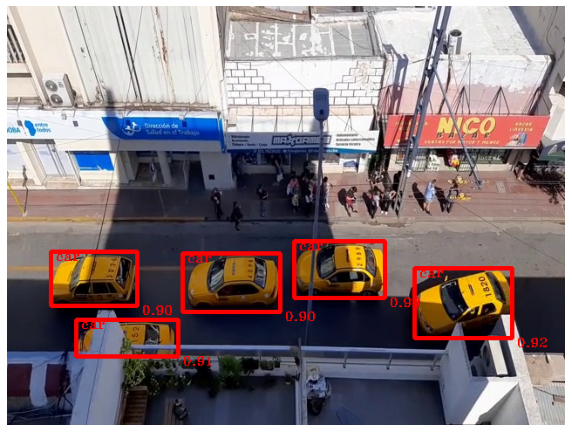

In [25]:
show_img_predictions(img_test, predictions_custom)

# Testing standard model

In [10]:
model_std = torch.hub.load('ultralytics/yolov5', 'yolov5l') 

Using cache found in /home/maxi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.10.4 torch-1.13.1+cu117 CPU



  0%|          | 0.00/89.3M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


In [26]:
def predict_as_df_std(img, conf_thres):
    results = model_std(img)
    df = results.pandas().xyxy[0]
    df = df[df["name"].isin(list(classes.values()))]
    df = df[df['confidence'] >= conf_thres]
    return df 

In [27]:
img_test = "train/frame_0200.jpeg"

In [28]:
predictions_std = predict_as_df_std(img_test, 0.3)
predictions_std

,xmin,ymin,xmax,ymax,confidence,class,name
0,206.605240,284.750732,312.601837,347.072205,0.926001,2,car
1,329.969055,270.470276,435.753784,335.034790,0.869438,2,car
2,232.474579,206.954575,248.592133,245.637527,0.685301,0,person
3,254.639328,224.701630,271.392334,258.100739,0.642549,0,person
4,48.279140,281.987396,149.862473,345.175568,0.608703,2,car
5,407.019012,212.106888,423.646942,244.337143,0.604548,0,person
6,378.755066,208.149002,396.559143,241.923752,0.596897,0,person
7,477.078308,198.553513,492.237305,239.078720,0.562813,0,person
8,387.969666,209.481262,400.557983,239.755554,0.520472,0,person
9,325.698059,210.906952,336.618896,238.266327,0.488994,0,person


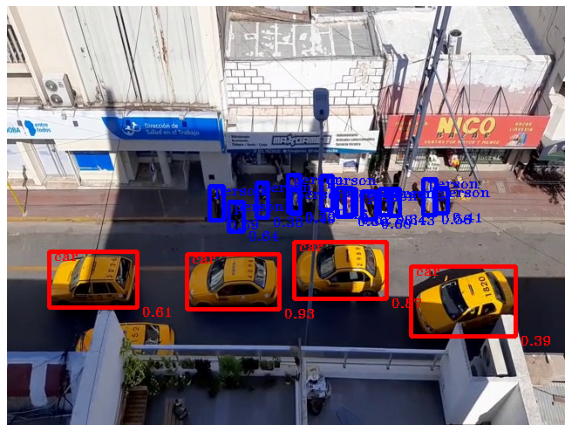

In [29]:
show_img_predictions(img_test, predictions_std)

# Label and output Annotated Video

In [30]:
basic_info_exp = get_basic_info(VIDEO_PATH_EXP)
basic_info_exp

{'width': 640,
 'height': 480,
 'frames': 1255,
 'fps': 30.0,
 'total_seconds': 41.833333333333336}

In [31]:
def add_annotations(img, predictions_df):
    font = cv2.FONT_HERSHEY_TRIPLEX
    img_ = img.copy()
    
    for i, d in predictions_df.iterrows():
        xmin, ymin, xmax, ymax = d["xmin"], d["ymin"], d["xmax"], d["ymax"]

        color = color_map[d['class']]

        pt1 = int(xmin), int(ymin)
        pt2 = int(xmax), int(ymax)
        img_ = cv2.rectangle(img_, pt1, pt2, color, 3)

        pt_text = pt1[0] + 5, pt1[1] + 10
        img_ = cv2.putText(img_, d["name"], pt_text, font, 0.5, color)

        confidence_label = f"{d['confidence']:.2f}"
        pt_conf = pt2[0] + 5, pt2[1] + 10
        img_ = cv2.putText(img_, confidence_label, pt_conf, font, 0.5, color)
        
    return img_

In [32]:
VIDEO_OUTPUT = f"./data/{video_name}_pred.mp4"

VIDEO_CODEC = "mp4v"
fps = basic_info_exp["fps"]
width = basic_info_exp["width"]
height = basic_info_exp["height"]
out = cv2.VideoWriter(VIDEO_OUTPUT,
    cv2.VideoWriter_fourcc(*VIDEO_CODEC),
    fps,
    (width, height))

cap = cv2.VideoCapture(VIDEO_PATH_EXP)
n_frames = basic_info_exp["frames"]

for frame in tqdm(range(n_frames), total=n_frames):
    ret, img = cap.read()
    if not ret : break
    
    pred_df = predict_as_df_std(img, 0.5)
    img_ = add_annotations(img, pred_df)
    out.write(img_)
    
out.release()
cap.release()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1255/1255 [18:16<00:00,  1.14it/s]


In [39]:
! ls data/

street0.mp4	       street0_exp.mp4	 street1.mp4
street0_compresed.mp4  street0_pred.mp4


In [41]:
#sp.run(['ffmpeg','-i', VIDEO_OUTPUT, '-qscale', '0', f"./data/{video_name}_pred_comp.mp4", '-loglevel', 'quiet'])

#sp.run(['ffmpeg', '-i', f"./data/{video_name}_pred_comp.mp4", '-vf', f'scale={witdh}:{height}', f"./data/{video_name}_pred_res.mp4", '-loglevel', 'quiet'])

CompletedProcess(args=['ffmpeg', '-i', './data/street0_pred_comp.mp4', '-vf', 'scale=640:480', './data/street0_pred_res.mp4', '-loglevel', 'quiet'], returncode=0)

In [42]:
ipd.Video(f"./data/{video_name}_pred_res.mp4", width=600)